# Given the stock information of at least the past 5 days of all companies, try to predict the closing price of one company on a particular day

# Load libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import root_mean_squared_error

# Load dataset and process Date

In [22]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_17724\4188221876.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")


# Retrieve the relevant information - instead of all 500 companies, use the companies belonging in the same industry as target company

In [23]:
# Define the company of interest
target_company = 'MMM'  # Replace with your target company name

# Ensure we have data for the target company
if target_company not in data['Symbol'].unique():
    raise ValueError(f"{target_company} is not in the dataset.")

# Filter data for the target company
target_data = data[data['Symbol'] == target_company].set_index('Date')

# Ensure we have enough data for the target company
if len(target_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# Get the industry of the target company
target_industry = target_data['GICS Sector'].iloc[0]  # Assuming 'Industry' is a column in your data

# Filter data for companies in the same industry
industry_data = data[data['GICS Sector'] == target_industry]

# Get the last n days of data for the target company
last_n_days_target = target_data['Close'].tail(120)

# Get the last n days of data for all companies in the same industry
last_n_days_industry = industry_data[industry_data['Date'].isin(last_n_days_target.index)]
avg_last_n_days = last_n_days_industry.groupby('Date')['Close'].mean()

print(target_data['GICS Sector'])
print(avg_last_n_days)


Date
2020-09-30    Industrials
2020-10-01    Industrials
2020-10-02    Industrials
2020-10-05    Industrials
2020-10-06    Industrials
                 ...     
2021-12-27    Industrials
2021-12-28    Industrials
2021-12-29    Industrials
2021-12-30    Industrials
2021-12-31    Industrials
Name: GICS Sector, Length: 317, dtype: object
Date
2021-07-14    179.929626
2021-07-15    179.875124
2021-07-16    179.089000
2021-07-19    175.514750
2021-07-20    180.193874
                 ...    
2021-12-27    187.920249
2021-12-28    188.843625
2021-12-29    189.259874
2021-12-30    188.392623
2021-12-31    189.320001
Name: Close, Length: 120, dtype: float64


# Perform rolling-window cross validation

In [24]:
# Define rolling window parameters
n = len(avg_last_n_days)
train_size = int(n * 0.8)
test_size = n - train_size
roll_window = 1  # Use a smaller value like 1 for rolling windows

In [25]:
# Define parameter combinations
param_combinations = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

results = []

# Rolling window cross-validation
for start in range(0, test_size, roll_window):
    train = avg_last_n_days.iloc[:train_size + start]
    test = avg_last_n_days.iloc[train_size + start: train_size + start + roll_window]
    
    for trend, seasonal in param_combinations:
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=12)
            fit = model.fit()
            
            # Forecast the next value(s)
            forecast = fit.forecast(roll_window)
            
            # Calculate RMSE
            rmse = root_mean_squared_error(test, forecast)  # Using squared=False for RMSE
            
            results.append({
                'trend': trend,
                'seasonal': seasonal,
                'start': start,
                'rmse': rmse,
            })
        except Exception as e:
            print(f"Error fitting model with trend={trend} and seasonal={seasonal}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Summarize results
summary = results_df.groupby(['trend', 'seasonal']).agg({'rmse': 'mean'}).reset_index()
print(summary)

# Find the row with the minimum RMSE
lowest_rmse_row = summary.loc[summary['rmse'].idxmin()]

# Extract the trend and seasonal values
lowest_trend = lowest_rmse_row['trend']
lowest_seasonal = lowest_rmse_row['seasonal']

print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")
print(f"Trend: {lowest_trend}, Seasonal: {lowest_seasonal}")

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

  trend seasonal      rmse
0   add      add  1.806460
1   add      mul  1.802648
2   mul      add  1.807633
3   mul      mul  1.803785
Lowest RMSE: 1.8026477547075583
Trend: add, Seasonal: mul


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Us

# Fit into model

In [26]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(
    avg_last_n_days,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7  # weekly seasonality
).fit()

# Forecast the next day's closing price
forecast = model.forecast(steps=1)

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Output and visualisation

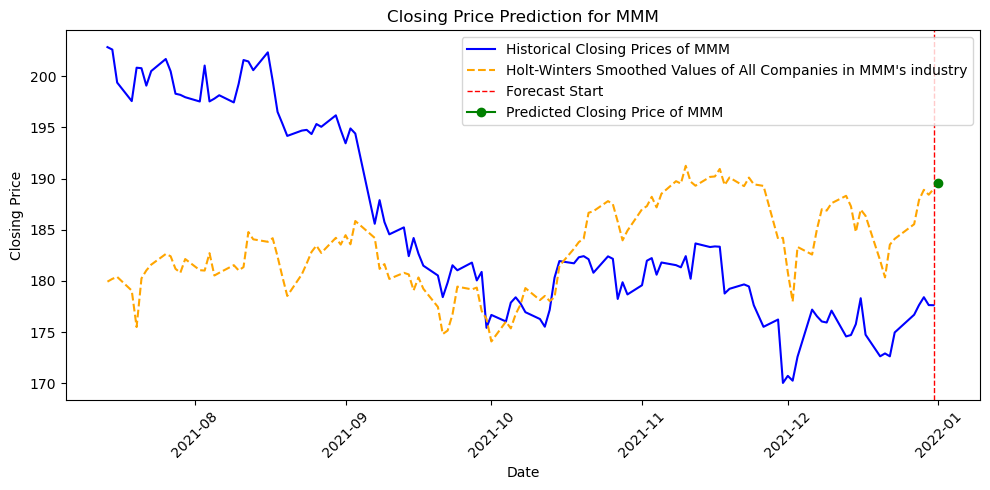

Predicted Closing Price for MMM on the next day: 189.60026733548708
Lowest RMSE: 1.8026477547075583


In [27]:
# Prepare data for visualization
smoothed_values = model.fittedvalues

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(last_n_days_target.index, last_n_days_target, label=f'Historical Closing Prices of {target_company}', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label= f"Holt-Winters Smoothed Values of All Companies in {target_company}'s industry", color='orange', linestyle='--')
plt.axvline(x=last_n_days_target.index[-1], color='red', linewidth=1, linestyle='--', label='Forecast Start')
plt.plot(last_n_days_target.index[-1] + pd.DateOffset(days=1), forecast, marker='o', label=f'Predicted Closing Price of {target_company}', color='green')
plt.title(f'Closing Price Prediction for {target_company}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price
print(f'Predicted Closing Price for {target_company} on the next day: {forecast.iloc[0]}')
print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")

# Repeat same process but with TEST data

In [31]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\test_data.csv")

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Define the company of interest
target_company = 'MMM'  # Replace with your target company name

# Ensure we have data for the target company
if target_company not in data['Symbol'].unique():
    raise ValueError(f"{target_company} is not in the dataset.")

# Filter data for the target company
target_data = data[data['Symbol'] == target_company].set_index('Date')

# Ensure we have enough data for the target company
if len(target_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# Get the industry of the target company
target_industry = target_data['GICS Sector'].iloc[0]  # Assuming 'Industry' is a column in your data

# Filter data for companies in the same industry
industry_data = data[data['GICS Sector'] == target_industry]

# Get the last n days of data for the target company
last_n_days_target = target_data['Close'].tail(120)

# Get the last n days of data for all companies in the same industry
last_n_days_industry = industry_data[industry_data['Date'].isin(last_n_days_target.index)]
avg_last_n_days = last_n_days_industry.groupby('Date')['Close'].mean()

print(target_data['GICS Sector'])
print(avg_last_n_days)



Date
2022-01-03    Industrials
2022-01-04    Industrials
2022-01-05    Industrials
2022-01-06    Industrials
2022-01-07    Industrials
                 ...     
2022-06-24    Industrials
2022-06-27    Industrials
2022-06-28    Industrials
2022-06-29    Industrials
2022-06-30    Industrials
Name: GICS Sector, Length: 124, dtype: object
Date
2022-01-07    186.634252
2022-01-10    185.213251
2022-01-11    186.574001
2022-01-12    186.851249
2022-01-13    186.552749
                 ...    
2022-06-24    158.666625
2022-06-27    158.528500
2022-06-28    156.316000
2022-06-29    155.628500
2022-06-30    156.493999
Name: Close, Length: 120, dtype: float64


In [32]:
# Define rolling window parameters
n = len(avg_last_n_days)
train_size = int(n * 0.8)
test_size = n - train_size
roll_window = 1  # Use a smaller value like 1 for rolling windows

# Define parameter combinations
param_combinations = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

results = []

# Rolling window cross-validation
for start in range(0, test_size, roll_window):
    train = avg_last_n_days.iloc[:train_size + start]
    test = avg_last_n_days.iloc[train_size + start: train_size + start + roll_window]
    
    for trend, seasonal in param_combinations:
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=12)
            fit = model.fit()
            
            # Forecast the next value(s)
            forecast = fit.forecast(roll_window)
            
            # Calculate RMSE
            rmse = root_mean_squared_error(test, forecast)  # Using squared=False for RMSE
            
            results.append({
                'trend': trend,
                'seasonal': seasonal,
                'start': start,
                'rmse': rmse,
            })
        except Exception as e:
            print(f"Error fitting model with trend={trend} and seasonal={seasonal}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Summarize results
summary = results_df.groupby(['trend', 'seasonal']).agg({'rmse': 'mean'}).reset_index()
print(summary)

# Find the row with the minimum RMSE
lowest_rmse_row = summary.loc[summary['rmse'].idxmin()]

# Extract the trend and seasonal values
lowest_trend = lowest_rmse_row['trend']
lowest_seasonal = lowest_rmse_row['seasonal']

print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")
print(f"Trend: {lowest_trend}, Seasonal: {lowest_seasonal}")

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

  trend seasonal      rmse
0   add      add  2.715707
1   add      mul  2.672784
2   mul      add  3.086222
3   mul      mul  2.670872
Lowest RMSE: 2.6708723741816036
Trend: mul, Seasonal: mul


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWar

In [33]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(
    avg_last_n_days,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7  # weekly seasonality
).fit()

# Forecast the next day's closing price
forecast = model.forecast(steps=1)

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


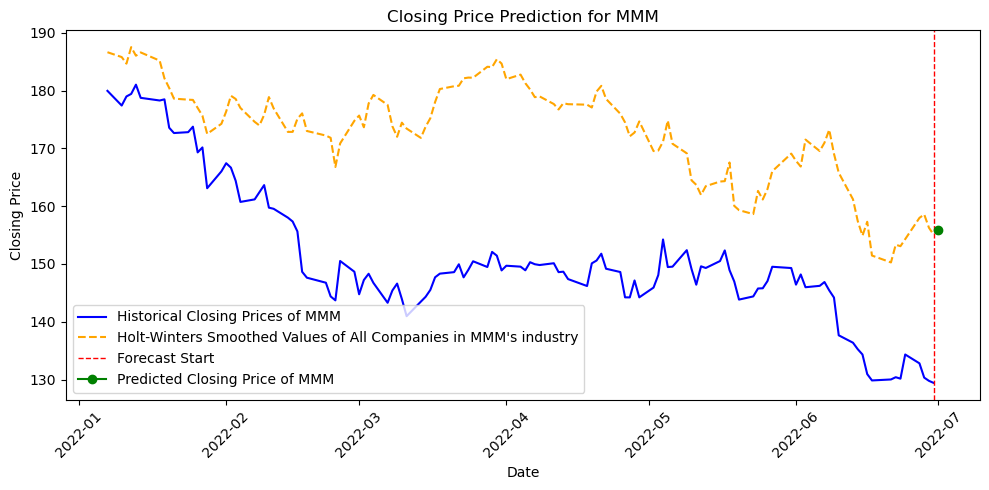

Predicted Closing Price for MMM on the next day: 155.78975443884238
Lowest RMSE: 2.6708723741816036


In [34]:
# Prepare data for visualization
smoothed_values = model.fittedvalues

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(last_n_days_target.index, last_n_days_target, label=f'Historical Closing Prices of {target_company}', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label= f"Holt-Winters Smoothed Values of All Companies in {target_company}'s industry", color='orange', linestyle='--')
plt.axvline(x=last_n_days_target.index[-1], color='red', linewidth=1, linestyle='--', label='Forecast Start')
plt.plot(last_n_days_target.index[-1] + pd.DateOffset(days=1), forecast, marker='o', label=f'Predicted Closing Price of {target_company}', color='green')
plt.title(f'Closing Price Prediction for {target_company}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price
print(f'Predicted Closing Price for {target_company} on the next day: {forecast.iloc[0]}')
print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")